# Download the VGG-16 checkpoint

In [1]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.


# Make a saliency map

INFO:tensorflow:Restoring parameters from /tmp/checkpoints/vgg_16.ckpt


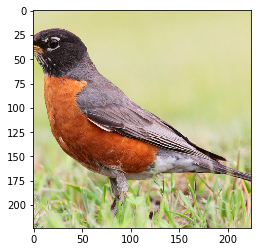

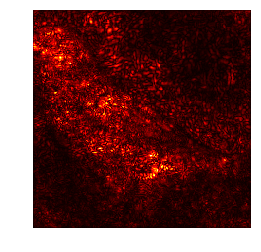

Probability 100.00% => [robin, American robin, Turdus migratorius]
Probability 0.00% => [worm fence, snake fence, snake-rail fence, Virginia fence]
Probability 0.00% => [brambling, Fringilla montifringilla]
Probability 0.00% => [water ouzel, dipper]
Probability 0.00% => [jacamar]


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

from tensorflow.contrib import slim

image_size = vgg.vgg_16.default_image_size

checkpoints_dir = '/tmp/checkpoints'

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Turdus-migratorius-002.jpg/1200px-Turdus-migratorius-002.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)

    processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Preprocess the image for display purposes.
    resize_image = vgg_preprocessing._aspect_preserving_resize(image, 256)
    center_crop_image = vgg_preprocessing._central_crop([resize_image], 224, 224)[0]
    image_raw = tf.expand_dims(center_crop_image, 0)
    image_raw = tf.image.resize_images(image_raw, [224, 224])
    image_raw = tf.squeeze(image_raw)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        # 1000 classes instead of 1001.
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)

        dX = tf.gradients(logits, processed_images)
        probabilities = tf.nn.softmax(logits)

    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        
        np_image, out, probabilities = sess.run([image_raw, dX, probabilities])
        saliency = np.max(np.abs(out[0]), axis=3)
        
    
    probabilities = probabilities[0, 0:]  
    sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]

        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.show()
    plt.imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()
    
    
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Shift the index of a class name by one. 
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))